<a href="https://colab.research.google.com/github/IFuentesSR/Reservoir_area_Sentinel2/blob/main/eflows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=PcU_5M_vBfW0mvs9MwgnRCtKRfAVkbnxW9WX4EwhiYo&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjoLSeC0EbBmCtbe71Sfo-r8QAL9hXlbXJxhkAXkUi9Oa29dieSz1A

Successfully saved authorization token.


In [ ]:
# Folium setup.
import os
import folium
import datetime
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import pearsonr


print(folium.__version__)

0.8.3


In [ ]:
def getS2_CLOUD_PROBABILITY(geo):
    innerJoined = ee.Join.inner().apply(primary=ee.ImageCollection("COPERNICUS/S2").filterBounds(geo).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 40)),
                                        secondary=ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY").filterBounds(geo),
                                        condition=ee.Filter.equals(leftField='system:index',
                                                                   rightField='system:index'))
    def mergeImageBands(joinResult):
        return ee.Image(joinResult.get('primary')).addBands(joinResult.get('secondary'))

    newCollection = innerJoined.map(mergeImageBands)
    return ee.ImageCollection(newCollection)


def WI(img):
    props = img.propertyNames()
    return img.expression('1.7204 + 171 * Green + 3 * Red - 70 * NIR - 45 * SWIR1 - 71 * SWIR2',
                          {'Green':img.select('B3'),'Red':img.select('B4'), 
                           'NIR':img.select('B8'),'SWIR1':img.select('B11'),
                           'SWIR2':img.select('B12')}).rename('WI').copyProperties(img, props)


def projectShadows(cloudMask, sunAzimuth, offset):
    azimuth = ee.Number(sunAzimuth).multiply(np.pi).divide(180.0).add(ee.Number(0.5).multiply(np.pi))
    x = azimuth.cos().multiply(15.0).round()
    y = azimuth.sin().multiply(15.0).round()
    shadow = cloudMask.changeProj(cloudMask.projection(), cloudMask.projection().translate(x.multiply(ee.Number(offset)), y.multiply(ee.Number(offset))))
    return shadow


def scale(img):
    props = img.propertyNames()
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    ob = ['B1', 'B9', 'B10', 'probability']
    scaled = img.select(bands).divide(10000)
    wi = ee.Image(WI(scaled)).rename('wi')
    return scaled.addBands(img.select(ob)).addBands(wi).copyProperties(img, 
                                                                       props)
    

def masking(img):
    props = img.propertyNames()
    img_scaled = ee.Image(scale(img))
    clouds = img_scaled.select('probability').gte(30)
    shadows = projectShadows(clouds,
                             img_scaled.get('MEAN_SOLAR_AZIMUTH_ANGLE'), 
                             img.get('MEAN_INCIDENCE_ZENITH_ANGLE_B10'))
    shadow_distance = shadows.fastDistanceTransform().sqrt()
    #Threshold on distance (five pixels) for a dilation.
    shadow_dilation = shadow_distance.lt(5)
    mask = clouds.Not().multiply(shadow_dilation.Not())
    return img_scaled.updateMask(mask).copyProperties(img_scaled, props)

In [ ]:
def water_mask(img):
    props = img.propertyNames()
    return img.select('wi').gt(0)


def unmasked_pixels(img):
    props = img.propertyNames()
    return img.select('B2').gt(-9999)


In [ ]:
def format_date(date):
    return ee.Date(date).format('YYYY-MM-dd')


def fea_merge(current, previous):
    coor = ee.Geometry(current.get('system:footprint')).coordinates()
    geo = ee.Feature(ee.Geometry.Polygon(coor), None)  
    return ee.Feature(previous).union(geo)


def mosaic_coll(date):
    date = ee.Date(date)
    single_coll = coll.filterDate(date, date.advance(1, 'day'))
    geo = ee.Feature(single_coll.iterate(fea_merge, ee.Feature(None, None)))
    geo_area = ee.Number(geo.area(1)).divide(10000)
    mosaic = single_coll.mosaic()
    thresholds = ee.Image(-9999).addBands(ee.Image(0))
    flooded = mosaic.select(['B2', 'wi']).gt(thresholds).multiply(ee.Image.pixelArea())
    dict_wet = flooded.reduceRegion(reducer=ee.Reducer.sum(),
                                    geometry=geo.geometry(),
                                    scale=10,
                                    maxPixels=1e13)
    wet_area = ee.Number(dict_wet.values().get(1)).divide(10000)
    unmasked = ee.Number(dict_wet.values().get(0)).divide(10000)
    len_coll = single_coll.size()
    return ee.Feature(None, {'date': date.format('YYYY-MM-dd'),
                             'wet_area': wet_area,
                             'outer_area': geo_area,
                             'unmasked_area': unmasked,
                             'length_collection': len_coll})
    

In [ ]:
geometry = ee.Geometry.Polygon([[[144.75196087944778, -35.640730290266404],
                                 [144.75196087944778, -36.563874198720754],
                                 [146.25708783257278, -36.563874198720754],
                                 [146.25708783257278, -35.640730290266404]]])

S2 = getS2_CLOUD_PROBABILITY(geometry).filter(ee.Filter.Or(ee.Filter.eq('MGRS_TILE', '55HCA'),
                                                           ee.Filter.eq('MGRS_TILE', '55HCV')))
coll = S2.map(masking)


In [ ]:
sum_coll = ee.Reducer.sum()
occurrence = coll.map(water_mask).reduce(sum_coll).divide(coll.map(unmasked_pixels).reduce(sum_coll))

In [ ]:
mapidCon = occurrence.getMapId({min:0, max:1})
centroid = geometry.centroid().coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=10)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='occurrence',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [ ]:
dates = coll.aggregate_array('system:time_start').map(format_date).distinct()
# ee.batch.Export.table.toDrive(ee.FeatureCollection(dates.slice(340, 486).map(mosaic_coll)), 'testing2').start()

# Get access to datasets

To obtain access to the datasets used in this work you need to follow the following steps:
* Click on [this](https://drive.google.com/drive/folders/1ME8fuUnS4VEgqBBpBf29uxrzcctvaOI-?usp=sharing) Google Drive folder link. 

* Then, right click on the **eflows_stations** folder and select **Add shortcut to Drive**.


* Make a shortcut of the **eflows_stations** folder in your own **My Drive**-folder, by clicking on **Add shortcut**. 


A new Google Drive folder with all the contents of this study has been linked to your Google Drive; therefore, we can link our Google Drive account to have access to the data.



## Inundated areas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### concatenating stored files of S2 wet_areas into single dataframe

In [ ]:
files = ['testing.csv', 'testing1.csv', 'testing2.csv']
station_paths = '/content/drive/My Drive/eflows_stations'
path_files = [os.path.join(station_paths, n) for n in files]
dfs = [pd.read_csv(n) for n in path_files]
df = pd.concat(dfs)
df = df.set_index(pd.to_datetime(df['date']))
df['ratio'] = df['unmasked_area'] / df['outer_area'].max()

### plotting time series of inundated areas

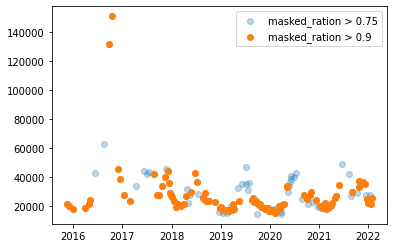

In [ ]:
df_sub = df[df['ratio'] > 0.9]
df_sub2 = df[df['ratio'] > 0.75]

plt.scatter(df_sub2.index, df_sub2['wet_area'], alpha=0.3, label='masked_ration > 0.75')
plt.scatter(df_sub.index, df_sub['wet_area'], label='masked_ration > 0.9')
plt.legend()

### Bringing gauge station data

In [ ]:
station_csv = '/content/drive/My Drive/eflows_stations/stations.csv'
df_stat = pd.read_csv(station_csv)
station_names = df_stat['station']
gauge_paths = ['{}/df{}.csv'.format(station_paths, str(n)) for n in station_names]

In [ ]:
m = folium.Map(location=centroid, zoom_start=9)
for n in range(len(df_stat)):
    folium.Circle([df_stat['latitude'][n], df_stat['longitude'][n]], 1000, fill=True).add_child(folium.Popup(str(df_stat.station[n]))).add_to(m)
    folium.map.Marker(
        [df_stat['latitude'][n], df_stat['longitude'][n]],
        icon=folium.features.DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 14pt">%s</div>' % str(df_stat.station[n]),
            )
        ).add_to(m)
m

In [ ]:
def read_station(name):
    sta = pd.read_csv(name)
    sta = sta.set_index(pd.to_datetime(sta[sta.columns[0]]))
    sta = sta.drop(sta.columns[0], axis=1)
    return sta


### Plotting discharge against inundated_areas

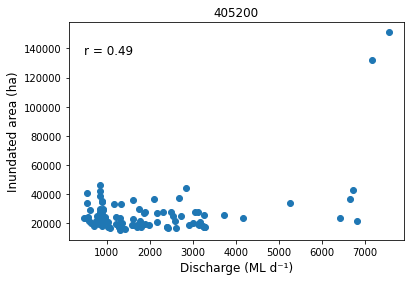

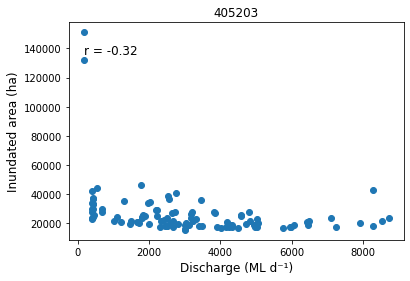

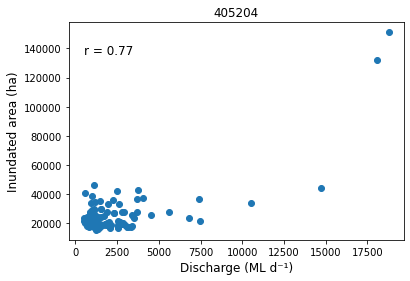

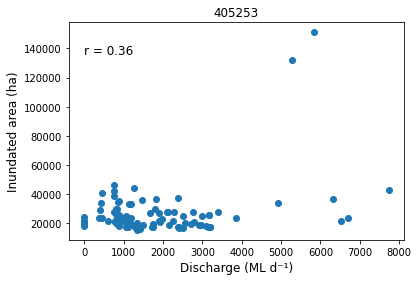

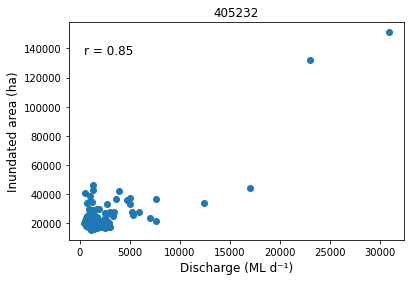

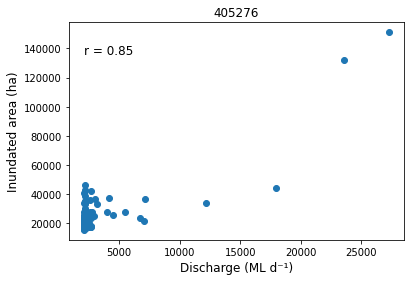

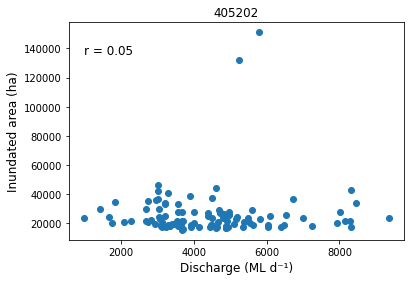

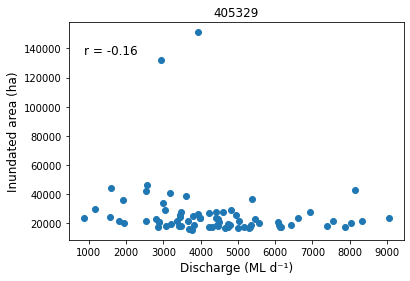

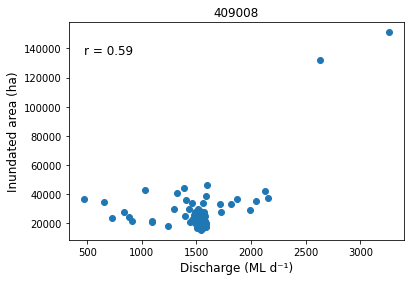

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


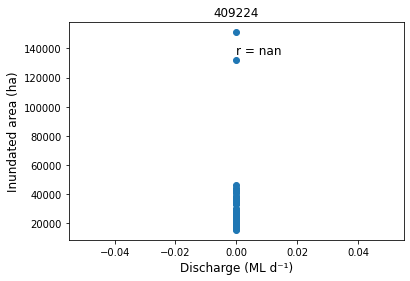

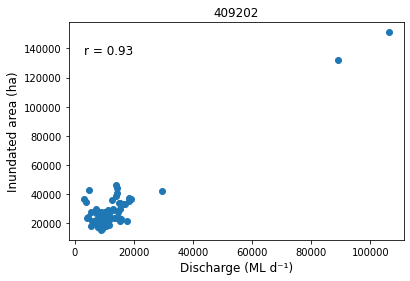

In [ ]:
for n in gauge_paths:
    try:
        dis = read_station(n)
        df_sub1 = df_sub.copy()
        df_sub1['discharge'] = dis[dis.columns[0]]
        df_sub1.dropna(how='any', inplace=True)
        r = np.round(pearsonr(df_sub1['discharge'], df_sub1['wet_area'])[0], 2)
        plt.scatter(df_sub1['discharge'], df_sub1['wet_area'])
        plt.text(df_sub1['discharge'].min(),
                 df_sub1['wet_area'].max()*0.9,
                 'r = '+str(r), fontsize=12)
        plt.title(n[-10:-4])
        plt.xlabel('Discharge (ML d⁻¹)', fontsize=12)
        plt.ylabel('Inundated area (ha)', fontsize=12)
        plt.show()
    except:
        continue
